# Pip Installs

In [1]:
%%capture

!pip install librosa
!pip install tensorflow
!pip install numpy==1.23.5
!pip install pysoundfile

Tensor flow does not work with Numpy 2.0 onward so make sure that 

# Imports

Below are the necessary imports 

In [2]:
#Imports
from pydub import AudioSegment as audio
import os
import numpy as np
import librosa
#Tensor Flow needs numpy at 1.23.5
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
import re 
import soundfile as sf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder

/Users/ryanbirmingham/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# File Creation

### Creating File Paths

In [3]:
unprocessed_data_dir = os.path.abspath('') + "/Unprocessed_Wav_Files"
proccesed_data_dir = os.path.abspath('') + "/Processed_Wav_Files"

Steps
- go through all files in the unprocessed wav files
- break up all files so they are split by 1 second
- use regex to get the file name minus the .wav at the end to make new 1 second wav files
- save each of the files into the processed wav folder

Resample the unproccessed audio files for speaker recognition. This is needed for tensorflow and keras

In [4]:
#This was a test for the fixing the audio with a single thing

"""
f_path = os.path.join(unproccessed_data_dir, "addisonWilson40173Clip1.wav")
arr, hz = librosa.load(f_path, sr = None)
new_f = librosa.resample(arr, orig_sr= hz, target_sr= 16000)
sf.write(os.path.join(unproccessed_data_dir,"new.wav"),new_f, 16000)
"""


'\nf_path = os.path.join(unproccessed_data_dir, "addisonWilson40173Clip1.wav")\narr, hz = librosa.load(f_path, sr = None)\nnew_f = librosa.resample(arr, orig_sr= hz, target_sr= 16000)\nsf.write(os.path.join(unproccessed_data_dir,"new.wav"),new_f, 16000)\n'

### Changes the Unporcessed_Wav_Files into 16000 hz

This is necessary for speaker recognition model training and feature extractions

In [5]:
for file in os.listdir(unprocessed_data_dir):
    f_path = os.path.join(unprocessed_data_dir, file)
    arr, hz = librosa.load(f_path,sr = None)
    if hz != 16000:
        new_f = librosa.resample(arr, orig_sr = hz, target_sr = 16000)
        sf.write(f_path, new_f, 16000)

This is a test

In [6]:
f_path = os.path.join(unprocessed_data_dir, "addisonWilson40173Clip1.wav")
arr, hz = librosa.load(f_path, sr = None)
print(hz)

16000


### Separates the files into 1 second intervals

In [7]:
for filename in os.listdir(unprocessed_data_dir):
    if filename.endswith(".wav"):
        hearing = audio.from_wav(os.path.join(unprocessed_data_dir,filename))
        speaker = filename.removesuffix(".wav")
        #name of congress person for processed_wav_files folder
        congress_name = speaker[:re.search(r"\d+",speaker).start()] 
        #start duration in milliseconds for audio recording start
        t1 = 0
        #end duration in milliseconds for audio recording start
        t2 = 1000
        #second of the clip
        second = 1
        total_time = hearing.duration_seconds*1000
        # Goes through all of the large audio files, splits them into 1 second audio files
        # and saves to the speaker name folder
        while t2 <= total_time:
            new_audio = hearing[t1:t2]
            #arr, hz = librosa.load(new_audio, sr = None)
            try:
                os.makedirs(f"{proccesed_data_dir}/{congress_name}")
                new_audio.export(f"{proccesed_data_dir}/{congress_name}/{speaker}_{second}.wav", format = "wav");
                #new_audio.export(f"{proccesed_data_dir}/{congress_name}/{speaker}_{second}.wav", format = "wav", parameters=["-ar", "16000"]);
            except:
                #new_audio.export(f"{proccesed_data_dir}/{congress_name}/{speaker}_{second}.wav", format = "wav", parameters=["-ar", "16000"]);
                new_audio.export(f"{proccesed_data_dir}/{congress_name}/{speaker}_{second}.wav", format = "wav");
            t1 += 1000
            t2 += 1000
            second += 1

Check the Hz of a split file

In [8]:
a,b = librosa.load(os.path.abspath('')  + "/Processed_Wav_Files/addisonWilson/addisonWilson40173Clip1_2.wav", sr = None)
print(b)

16000


### Feature Extraction

In [9]:
def feature_extract (data_dir):
    features = []
    labels = []
    for foldr in os.listdir(data_dir):
        if foldr != ".DS_Store":
            for file in os.listdir(f"{data_dir}/{foldr}"):
                arr, hz = librosa.load(os.path.join(data_dir,foldr,file), sr = None, duration =  1)
                mfccs = librosa.feature.mfcc(y = arr, sr = hz, n_mfcc = 13)
                mfccs = StandardScaler().fit_transform(mfccs)
                features.append(mfccs.T)
                labels.append(foldr)       
    return np.array(features), np.array(labels)           
features, labels = feature_extract(proccesed_data_dir)

### Feature Visualization

In [10]:
for feature_set, label in zip(features, labels[74:150]):
    print(f"Label: {label}, Features Shape: {feature_set.shape}")
    print(feature_set[0])  # Optionally print the actual features
    print("-" * 40)  # Separator for readability

Label: kevinKiley, Features Shape: (32, 13)
[-3.4058075   0.6767028   0.16349712  0.66548455  0.28365508  0.315916
  0.29496303  0.3013779   0.19241706  0.1582042   0.03784923  0.18544002
  0.1303007 ]
----------------------------------------
Label: kevinKiley, Features Shape: (32, 13)
[-3.0419765   1.4925851  -0.63399875  0.72828877  0.25695843 -0.22482337
  0.27614018  0.01380512  0.2993842   0.43216932 -0.05315855  0.15443161
  0.3001944 ]
----------------------------------------
Label: victoriaSpartz, Features Shape: (32, 13)
[-3.1619763   1.3241143  -0.18580197  0.94523466  0.28509158  0.07677993
  0.3953385   0.1450311   0.19954966  0.09636918 -0.02315987 -0.01802384
 -0.07854712]
----------------------------------------
Label: victoriaSpartz, Features Shape: (32, 13)
[-2.942654    1.6622137  -0.8224903   0.48869875  0.03246037 -0.06752822
  0.32346418 -0.0838229   0.35962188  0.5789768   0.22027598  0.10617795
  0.1446057 ]
----------------------------------------
Label: victori

### Training and splitting the data

In [11]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size= .2, random_state= 42)

In [12]:
#Original shape shows n_samples, n_features, and n_channels
print(X_train.shape)

(1796, 32, 13)


### Reshape for SVM since it takes 2D arrays

In [13]:
X_train_SVM = X_train.reshape(X_train.shape[0], -1)
X_test_SVM = X_test.reshape(X_test.shape[0], -1)

### Trying the SVM approach

In [14]:
clm = SVC(kernel="linear")
clm.fit(X_train_SVM,y_train)

y_predict = clm.predict(X_test_SVM)
incorrect = y_predict != y_test
print((len(y_test) - sum(incorrect))/len(y_test))

0.7755555555555556


In [15]:
total = 0
predict = 0
real_dict = {}
pred_dict = {}

for i in labels:
    real_dict[i] = 0
    pred_dict[i] = 0

for pred, real in zip(y_predict,y_test):
    real_dict[real] += 1
    pred_dict[real] += 1 if real == pred else 0
for name in real_dict:
    print(
         f"{name} \n\taccuracy = {pred_dict[name]/real_dict[name]}" 
         f"\n\tpredict/real = {pred_dict[name]}/{real_dict[name]}"
         )

kevinKiley 
	accuracy = 0.9333333333333333
	predict/real = 14/15
victoriaSpartz 
	accuracy = 0.7692307692307693
	predict/real = 20/26
richardlarsen 
	accuracy = 0.5714285714285714
	predict/real = 8/14
samuelgraves 
	accuracy = 0.65625
	predict/real = 21/32
christineSmith 
	accuracy = 0.5263157894736842
	predict/real = 10/19
michaelQuigley 
	accuracy = 0.5384615384615384
	predict/real = 7/13
addisonWilson 
	accuracy = 0.96045197740113
	predict/real = 170/177
michaelLawler 
	accuracy = 0.35
	predict/real = 7/20
stephencohen 
	accuracy = 0.7094017094017094
	predict/real = 83/117
sheldonWhitehouse 
	accuracy = 0.5294117647058824
	predict/real = 9/17


## Try RNN approach

### Label Encoding

In [16]:
label_encoder = LabelEncoder()
label_enc = label_encoder.fit_transform(labels)
#label_encoder.classes_ = np.array(labels)
X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn = train_test_split(features, label_enc, test_size=0.2, random_state=42)

In [17]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(128, input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(len(label), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
#history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32)
history = model.fit(X_train_rnn, y_train_rnn, epochs=20, batch_size=32)

/Users/ryanbirmingham/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.3786 - loss: 2.0262
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.5080 - loss: 1.5499
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.6396 - loss: 1.1612
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.7508 - loss: 0.8543
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.7582 - loss: 0.8133
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.7852 - loss: 0.6876
Epoch 7/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.7973 - loss: 0.6357
Epoch 8/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.7998 - loss: 0.6272
Epoch 9/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.8194 - loss: 0.5364
Epoch 10/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.8302 - loss: 0.5304
Epoch 11/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.8330 - loss: 0.5236
Epoch 12/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy:

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
Prediction time: 1.431899070739746
450
Test Evaluation Accuracy: 0.8355555555555556


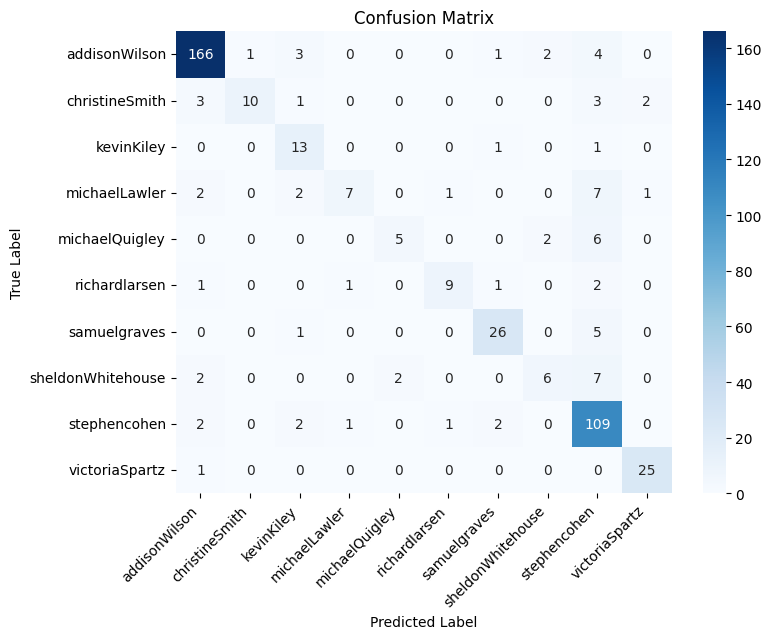

In [18]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import time
start_time = time.time()
y_pred_probabilities = model.predict(X_test_rnn)
print("Prediction time:", time.time() - start_time)

y_pred = np.argmax(y_pred_probabilities, axis=1)

# Decode the labels back to original format
y_test_decoded = label_encoder.inverse_transform(y_test_rnn)
y_pred_decoded = label_encoder.inverse_transform(y_pred)
print(len(y_pred_decoded))
# Create a confusion matrix
conf_matrix = confusion_matrix(y_test_decoded, y_pred_decoded, labels=np.unique(labels))

# Calculate accuracy
accuracy = accuracy_score(y_test_decoded, y_pred_decoded)
print(f"Test Evaluation Accuracy: {accuracy}")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)

# Rotate x-axis labels by 45 degrees
plt.xticks(rotation=45, ha="right")

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

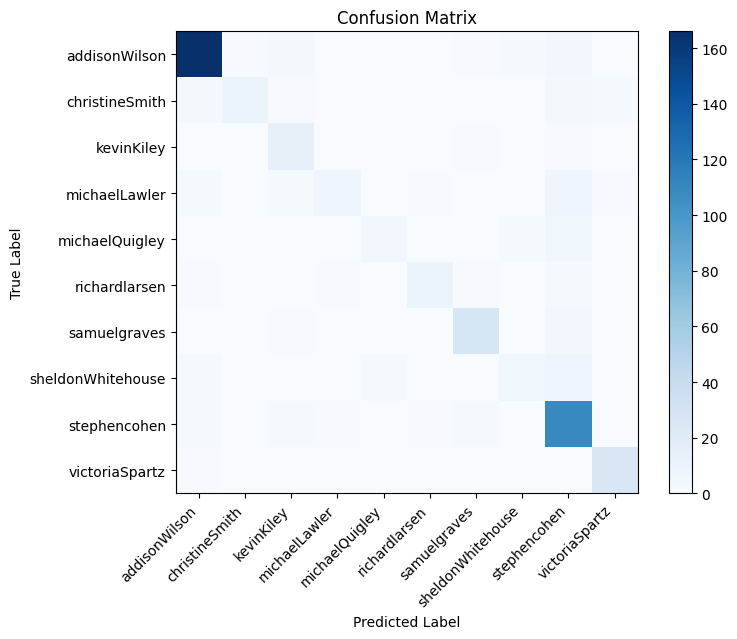

In [19]:
plt.figure(figsize=(8, 6))

# Display the confusion matrix using imshow
plt.imshow(conf_matrix, cmap="Blues", interpolation="nearest")
plt.colorbar()

# Use label_encoder.classes_ for the labels to match the classes in the matrix
plt.xticks(np.arange(len(label_encoder.classes_)), label_encoder.classes_, rotation=45, ha="right")
plt.yticks(np.arange(len(label_encoder.classes_)), label_encoder.classes_)

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Show the plot
plt.show()